# Fit beta distributions to the simulations
This will require monitoring and quality control and thus an interactive approach

In [4]:
import sqlite3 
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1001 # random seed 
}

In [9]:
con=sqlite3.connect('./simulations.db') 
cur = con.cursor()
# load table from database into pandas dataframe
simulations = pd.read_sql_query("SELECT * from simulations", con)
con.close()

In [10]:
# Select parameters to analyse and reduce dataframe
selection= simulations[(simulations['seed']==params['seed']) & (simulations['mu']==params['mu']) & (simulations['K']==params['K']) & (simulations['N']==params['N'])]
selection

,simulation_id,N,K,lambda,mu,h,window,seed,raw_file,dataset
0,1,10000,100,0.0000,0.2,1.000000e+00,0.000001,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1e-06
1,2,10000,100,0.0000,0.2,1.000000e+00,1.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0
2,3,10000,100,0.0000,0.2,1.000000e+00,10.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0
3,4,10000,100,0.0000,0.2,1.000000e+00,100.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0
4,5,10000,100,0.0000,0.2,1.000000e+00,1000.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0
...,...,...,...,...,...,...,...,...,...,...
3157,3158,10000,100,0.9999,0.2,5.623413e-07,1.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0
3158,3159,10000,100,0.9999,0.2,5.623413e-07,10.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0
3159,3160,10000,100,0.9999,0.2,5.623413e-07,100.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0
3160,3161,10000,100,0.9999,0.2,5.623413e-07,1000.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0


## Empirical probability mass function 

Make histogram with highes resolution and normalize to one. Since we are considering kernel-smoothing here, there is no exact binning. Still, the central limit theorem will apply for windows of size $W$ to leading order and we accordingly choose a binning

$$\Delta a = 1/N/\sqrt{W} $$

In [51]:
outfile = f'./dat/empirical_pmf_N={params["N"]}_K={params["K"]}_mu={params["mu"]}_seed={params["seed"]}.h5'

for i, sim in tqdm(selection.iterrows(), total=len(selection)):
    window = sim['window']
    lambda_ = sim['lambda']
    h = sim['h']
    # support (resolution of neural activity)
    delta = 1/params['N']
    support = np.arange(0, 1+delta, delta)
    # raw_file 
    raw_file = sim['raw_file']
    # dataset in raw_file
    dataset = sim['dataset']
    # load data from dataset in raw_file (hdf5)
    with h5py.File(raw_file, 'r') as file:
        data = np.array(file[dataset])
        # histogram
        pmf, _ = np.histogram(data, bins=support)
        # normalize
        pmf = pmf/np.sum(pmf)
        
    # store to outfile
    with h5py.File(outfile, 'a') as file:
        file.create_dataset(f'window={window}/1-lambda={1-lambda_}/h={h}/pmf', data=pmf)



100%|██████████| 3162/3162 [10:03<00:00,  5.24it/s]


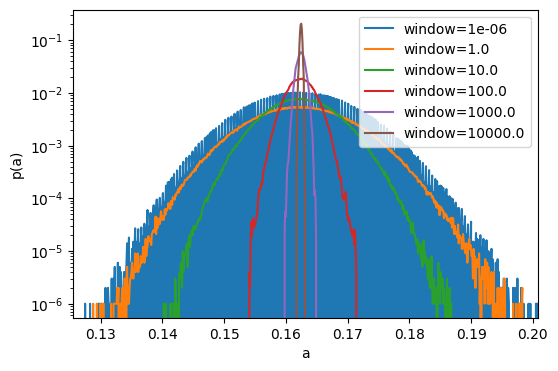

In [52]:
# Plot some example PMFs
sel = selection[(selection['lambda']==0.9) & (selection['h']==0.1)]
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
range_data = [1,0]
for i,sim in sel.iterrows():
    delta = 1/params['N']
    support = np.arange(0, 1+delta, delta)
    # pmf from simulation
    with h5py.File(sim['raw_file'], 'r') as file:
        data = np.array(file[f'{sim["dataset"]}'])
        pmf = np.histogram(data, bins=support)[0]
        pmf = pmf/np.sum(pmf)
    ref = ax.plot(support[:-1], pmf, label=f'window={sim["window"]}')
    range_data[0] = min(range_data[0], support[np.nonzero(pmf)][0])
    range_data[1] = max(range_data[1], support[np.nonzero(pmf)][-1])
    # if window >=1:
    #     with h5py.File(outfile, 'r') as file:
    #         pmf = np.array(file[f'window={sim["window"]}/1-lambda={1-sim["lambda"]}/h={sim["h"]}/pmf'])
    #     ax[0].plot(support[:-1], pmf, '-', color=ref[0].get_color())
ax.set_xlim(range_data)
ax.set_xlabel('a')
ax.set_ylabel('p(a)')
ax.set_yscale('log')
plt.legend(loc='upper right')
